**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [23]:
#Importing packages 
import numpy as np
import sympy as sm
import numba as nb
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize
from scipy import optimize
from scipy.stats import norm
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [4]:
# write your code here
#Defining symbols
C = sm.symbols('C')
G = sm.symbols('G')
alpha = sm.symbols('alpha')
L = sm.symbols('L')
nu = sm.symbols('nu')
kappa = sm.symbols('kappa')
tau = sm.symbols('tau')
w = sm.symbols('w')
wbar = sm.symbols('wbar')
sigma = sm.symbols('sigma')
rho = sm.symbols('rho')
epsilon = sm.symbols('epsilon')

In [5]:
#Defining utility function and budget constaint
utility = sm.log(C**alpha*G**(1-alpha))-nu*L**2/2
utility

budget_constraint = kappa+(1-tau)*w*L

In [6]:
# Substituting C into the utility function
utility_subs = utility.subs(C, budget_constraint)
utility_subs

-L**2*nu/2 + log(G**(1 - alpha)*(L*w*(1 - tau) + kappa)**alpha)

In [7]:
#Take first order condition with respect to L
foc_L = sm.diff(utility_subs, L)
foc_L

G**(1 - alpha)*G**(alpha - 1)*alpha*w*(1 - tau)/(L*w*(1 - tau) + kappa) - L*nu

In [8]:
#Solve for L
sol_L = sm.solve(sm.Eq(foc_L,0), L)
sol_L[0]

(kappa*nu - sqrt(nu*(4*alpha*tau**2*w**2 - 8*alpha*tau*w**2 + 4*alpha*w**2 + kappa**2*nu)))/(2*nu*w*(tau - 1))

We verify this is indeed the correct answer
$$L^*(\bar{w})=\frac{\kappa\nu-\sqrt{\nu(4\alpha\tau^2w^2-8\alpha\tau w^2+4\alpha w^2+\kappa^2\nu)}}{2\nu w(\tau-1)}\iff$$
$$L^*(\bar{w})=\frac{-\kappa+\sqrt{\frac{1}{\nu}(4\alpha\tau^2w^2-8\alpha\tau w^2+4\alpha w^2+\kappa^2\nu)}}{2\nu w(1-\tau)}\iff$$
$$L^*(\bar{w})=\frac{-\kappa+\sqrt{\frac{1}{\nu}(4\alpha(\tau^2w^2-2\tau w^2+w^2)+\kappa^2\nu)}}{2 w(1-\tau)}$$
Apply $\left((1-\tau)w\right)^2=w^2+\tau^2w^2-2\tau w^2$
$$L^*(\bar{w})=\frac{-\kappa+\sqrt{\frac{1}{\nu}(4\alpha\left((1-\tau)w\right)^2+\kappa^2\nu)}}{2 w(1-\tau)}\iff$$
$$L^*(\bar{w})=\frac{-\kappa+\sqrt{\kappa^2+4\frac{\alpha}{\nu}\bar{w}^2}}{2\bar{w}}$$

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [9]:
#We lambdify the supply of labor
L_opt_func = sm.lambdify(args=(alpha,kappa,nu,w,tau),expr=sol_L[0])

#Assign values to the paramters.
alpha_val = 0.5
kappa_val = 1.0
nu_val = 1/(2*16**2)
w_val = np.linspace(-1.2e-08, 10, num=1000)
tau_val = 0.3

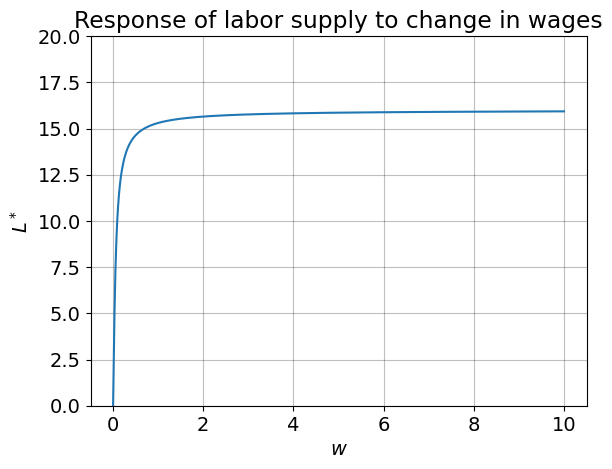

In [10]:
L_opt_func_sol = L_opt_func(alpha_val, kappa_val, nu_val, w_val, tau_val)

#Create empty space
L_values = np.zeros((len(w_val),))

#Calculate equillbria for different values of beta and store in arrays defined above
for v, d in enumerate(L_opt_func_sol):
    L_values[v] = d

fig = plt.figure()
plt.plot(w_val,L_values)
plt.xlabel(r'$w$')
plt.ylabel(r'$L^*$')
plt.title('Response of labor supply to change in wages')
plt.ylim(0, 20)

# show the plot
plt.show()

Labor supply exhibits a considerable degree of responsiveness to changes in wages at lower wage leves. However, as wage levels ascend, the elasticity of labor supply diminishes substantially, approaching a state of approximate inelasticity.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [11]:
# The function cannot be solved analytically. We apply numerical optimization.

#Define opbjective function
def objective_function(L, tau, kappa, w, alpha, nu):
    C = kappa + (1-tau) * w * L
    G = tau * w * L
    return -(np.log(C**alpha*G**(1-alpha))-nu*L**2/2)


#We set wages to constant and vary taxes
tau_values = np.linspace(1e-08, 1, num=1000)
w_val = 1

#Define empty spaces
sol_L_tau = []
sol_u_tau = []
sol_G_tau = []

#Bounds on L
bounds = [(0, 24)]

#Optimize
for tau_val in tau_values:
    result = minimize_scalar(lambda x: objective_function(x, tau_val, kappa_val, w_val, alpha_val, nu_val), bounds=bounds, method='golden' )
    optimal_L = result.x
    optimal_func_value = -objective_function(optimal_L, tau_val, kappa_val, w_val, alpha_val, nu_val)
    optimal_G = tau_val*w_val*optimal_L
    sol_L_tau.append(optimal_L)
    sol_u_tau.append(optimal_func_value)
    sol_G_tau.append(optimal_G)

/var/folders/2d/ksv407rj30z_gz_g2npsz8br0000gn/T/ipykernel_53523/4219039654.py:7: RuntimeWarning: divide by zero encountered in log
  return -(np.log(C**alpha*G**(1-alpha))-nu*L**2/2)
/Users/frederik/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2769: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


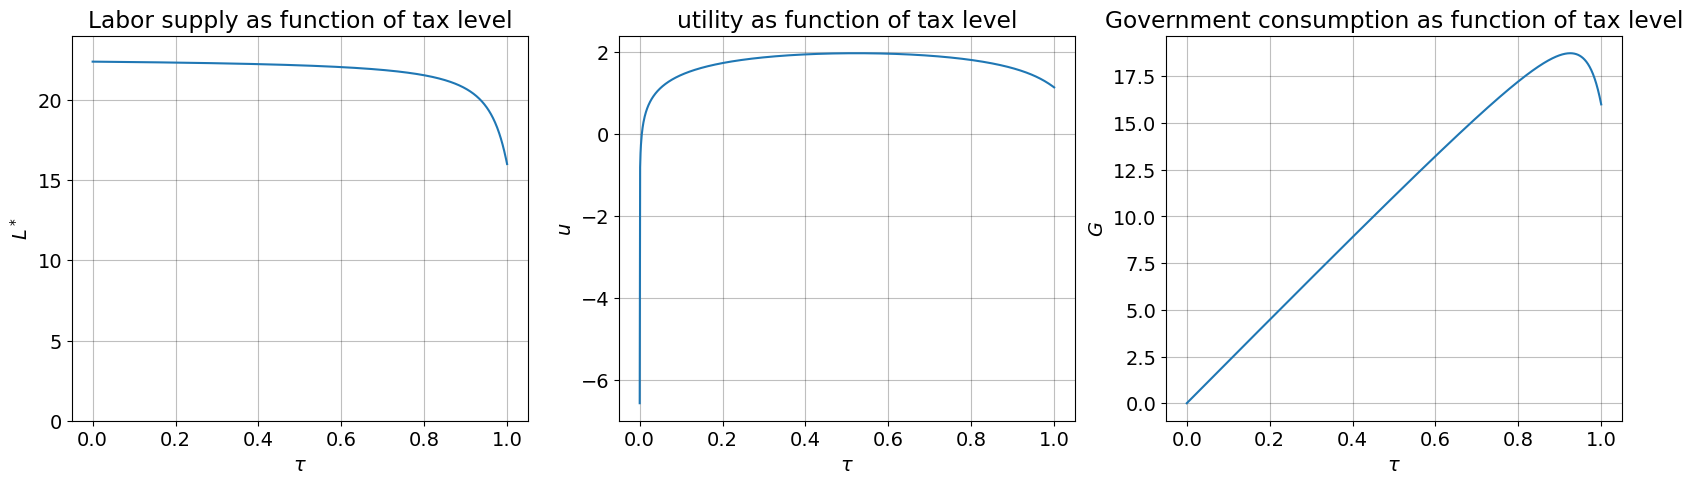

In [12]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(tau_values,sol_L_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$L^*$')
plt.title('Labor supply as function of tax level')
plt.ylim(0, 24)

plt.subplot(1,3,2)
plt.plot(tau_values,sol_u_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$u$')
plt.title('utility as function of tax level')

plt.subplot(1,3,3)
plt.plot(tau_values,sol_G_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$G$')
plt.title('Government consumption as function of tax level')
plt.show()

Labor supply demonstrates a low response to changes in tax rates, particularly when tax levels are relatively low. However, as tax rates escalate, the responsiveness of labor supply intensifies. However, even under conditions of complete taxation, labor continues to be supplied, as it contributes to government consumption.

The relationship between tax rates and utility can be characterized by an upward U-shaped curve. Both private and public consumption are deemed essential goods, indicating that a high marginal utility is necessary to acquire public consumption, particularly when tax rates are low.

Government consumption adheres to a Laffer curve, exhibiting maximal levels at approximately a 90 percent tax rate. Beyond this point, the impact of diminishing labor supply dominates the influence of further tax rate increases.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

The socially optimal tax rate is: 0.5225225272972973


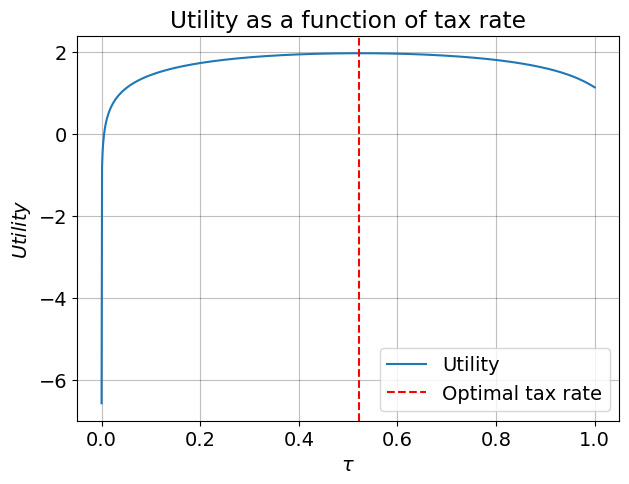

In [13]:
# Get the index of the maximum utility
max_u_index = np.argmax(sol_u_tau)

# Get the corresponding optimal tax rate
optimal_tau = tau_values[max_u_index]

print(f'The socially optimal tax rate is: {optimal_tau}')

# Illustrate the result
fig = plt.figure(figsize=(7,5))
plt.plot(tau_values, sol_u_tau, label='Utility')
plt.axvline(x=optimal_tau, color='red', linestyle='--', label='Optimal tax rate')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$Utility$')
plt.title('Utility as a function of tax rate')
plt.legend()
plt.show()


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [14]:
# Define objective function
def objective_function_ces(L, tau, kappa, w, alpha, nu, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    G = tau * w * L
    return -((((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma))**(sigma/(1-sigma)))**(1-rho)-1)/(1-rho)-nu*L**(1+epsilon)/(1+epsilon))

# set paramter values
tau_val = optimal_tau
sigma_val = 1.001
rho_val = 1.001
epsilon_val = 1.0

# Bounds on L
bounds = [(0, 24)]

# Restrict C>0 and G>0
cons = [{'type':'ineq', 'fun': lambda x: kappa_val + (1 - tau_val) * w_val * x},
        {'type':'ineq', 'fun': lambda x: tau_val * w_val * x}]

# Optimize with constraints
result_ces = minimize(lambda x: objective_function_ces(x, tau_val, kappa_val, w_val, alpha_val, nu_val, sigma_val, rho_val, epsilon_val),
                      x0=0, bounds=bounds, constraints=cons)

optimal_L_ces = result_ces.x[0]
optimal_func_value_ces = objective_function_ces(optimal_L_ces, tau_val, kappa_val, w_val, alpha_val, nu_val, sigma_val, rho_val, epsilon_val)
optimal_G_ces = tau_val * w_val * optimal_L_ces

print(optimal_L_ces)
print(optimal_func_value_ces)
print(optimal_G_ces)


0.0
-500.3464535048288
0.0


There is something wrong with this one. 

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.


In the absence of an answer from question 5, the resolution of this matter becomes challenging. However, assuming that reasonable solutions were obtained from question 5, we could incorporate the optimal labor supply and government spending into the utility function and iteratively modify the parameter tau to search for the maximum value. This process closely resembles the methodology employed in question 4.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [15]:
# write your code here
# Define the proposed optimal labor function
def optimal_labor(kappa):
    return ((1 - eta) * kappa / w) ** (1 / eta)

# Define the profit function
def profit(l, kappa):
    return kappa * l ** (1 - eta) - w * l

# Assigning values to parameters
eta = 0.5
w = 1.0
kappa_values = [1.0, 2.0]

# Create empty arrays to store the results
calculated_optimal_labor_values = np.zeros(len(kappa_values))
proposed_optimal_labor_values = np.zeros(len(kappa_values))

# Loop over kappa values and solve the profit function
for i, kappa in enumerate(kappa_values):
    result = optimize.minimize_scalar(lambda l: -profit(l, kappa), method='golden')
    calculated_optimal_labor = result.x
    proposed_optimal_labor = optimal_labor(kappa)
    
    # Store results
    calculated_optimal_labor_values[i] = calculated_optimal_labor
    proposed_optimal_labor_values[i] = proposed_optimal_labor

# Check if the calculated and proposed optimal labor values are close
print(f"The calculated optimal labor values: {calculated_optimal_labor_values}")
print(f"The proposed optimal labor values: {proposed_optimal_labor_values}")


The calculated optimal labor values: [0.25 1.  ]
The proposed optimal labor values: [0.25 1.  ]


IN this question we verify the analytical result numerically as to what the optimal amount of labour that maximizes the salon’s profit is.

The calculated optimal labor values are 0,25 and 1, which perfectly match our numerical result. This is a confirmation that the proposed labor function does maximize the salon’s profit

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [16]:
# write your code here 
# Define the demand shock
def demand_shock(rho, sigma_epsilon, kappa_prev):
    epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon)
    return np.exp(rho * np.log(kappa_prev) + epsilon)

# Define the policy for labor
def labor_policy(kappa, eta, w):
    return ((1-eta)*kappa/w)**(1/eta)

# Define the parameters
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
eta = 0.5
w = 1.0
T = 120  # number of periods
K = 10000  # number of simulations

# First demand shock
kappa_minus_1 = 1

# Create empty array to store the results
H_values = np.zeros(K)

# Perform the simulation
for k in range(K):
    # emand shock and labor
    kappa_prev = kappa_minus_1
    labor_prev = 0
    # Sum of the salon's value
    h_sum = 0
    # Simulate for each period
    for t in range(T):
        # Calculate the demand shock
        kappa = demand_shock(rho, sigma_epsilon, kappa_prev)
        # Calculate the optimal labor
        labor = labor_policy(kappa, eta, w)
        # Calculate the value of the salon
        h_value = kappa*labor**(1-eta) - w*labor - iota*(labor != labor_prev)
        h_sum += R**(-t) * h_value
        # Update the previous values
        kappa_prev = kappa
        labor_prev = labor
    
    # Storing the value of the salon for this simulation
    H_values[k] = h_sum

# Calculating the ex-ante expected value of the salon
H = np.mean(H_values)
print(f"The ex-ante expected value of the salon is: {H}")

The ex-ante expected value of the salon is: 27.71518008432648


We extend the problem to a dynamic setting where the demand shock follows an AR(1) process. The salon owner needs to take the fixed adjustment costs into account when they change the level of labor. In this setting, hte optimal labor choice therefore also depends on the previous level of labor and not only the demand shock.

We use 10.000 simulations in our Monte carlo simulation and denote the expected value of the Salon as “H”. The expected value of the salon with the optimal labor policy is around 27.7

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [17]:
# write your code here
#New policy
def policy_new(lt_minus1, kappa_t, eta, w, Delta):
    lt_star = ((1 - eta) * kappa_t / w) ** (1 / eta)
    if abs(lt_minus1 - lt_star) > Delta:
        return lt_star
    else:
        return lt_minus1

# Adding Delta
Delta = 0.05


H_values = []  # Storing H for each simulation

for k in range(K):
    lt_minus1 = 0
    total_profit = 0
    epsilon_series = np.random.normal(-0.5 * sigma_epsilon**2, sigma_epsilon, 120)
    kappa_series = np.empty(120)
    kappa_series[0] = np.exp(rho * np.log(1) + epsilon_series[0])  # kappa_-1 = 1

    for t in range(1, 120):  # kappa_0 is already set
        kappa_series[t] = np.exp(rho * np.log(kappa_series[t - 1]) + epsilon_series[t])
    
    for t in range(1, 120):
        lt = policy_new(lt_minus1, kappa_series[t], eta, w, Delta)
        total_profit += R**-t * (kappa_series[t] * lt**(1 - eta) - w * lt - int(lt != lt_minus1) * iota)
        lt_minus1 = lt

    H_values.append(total_profit)

# Calculating H
H = np.mean(H_values)
print("Expected value of H:", H)


Expected value of H: 28.165927122386574


Now the labor policy is changes so that the salon owner changes labor level if the difference between current optimal labor level and previous labor level exceeds a threshold $\delta$.  Point of policy is to avoid adjust ment cost when the optimal level of labor does not differ significantly from previous.

With $\delta=0.05$ the expected value of salon increases to around 28.5. Thereby it can be confirmed that profitability can be increased by avoiding minor adjustments in labor due to saved adjustment costs

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The optimal Delta value is: 0.07368421052631578


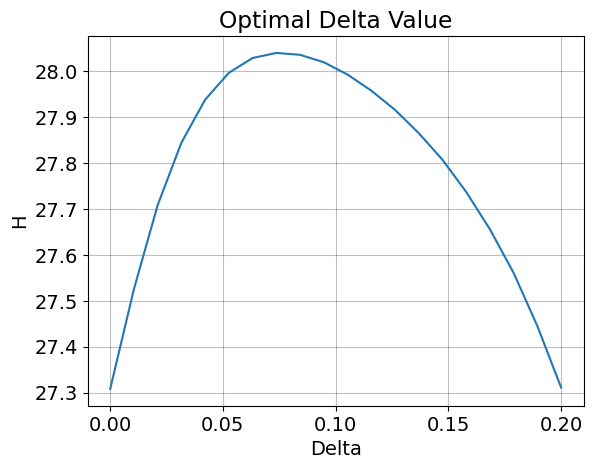

In [18]:

@nb.njit
def policy_new(lt_minus1, kappa_t, eta, w, Delta):
    lt_star = ((1 - eta) * kappa_t / w) ** (1 / eta)
    return lt_star if abs(lt_minus1 - lt_star) > Delta else lt_minus1

# Define a range of Delta values to search over
Delta_values = np.linspace(0, 0.2, 20)

# Array to store H for each Delta
H_values = np.zeros_like(Delta_values)

# Arrays for epsilon_series and kappa_series
epsilon_series = np.empty((K, 120))
kappa_series = np.empty((K, 120))

# Calculate epsilon_series and kappa_series
for k in nb.prange(K):
    epsilon_series[k] = np.random.normal(-0.5 * sigma_epsilon**2, sigma_epsilon, 120)
    kappa_series[k, 0] = np.exp(rho * np.log(1) + epsilon_series[k, 0])  # kappa_-1 = 1
    for t in range(1, 120):  # kappa_0 is already set
        kappa_series[k, t] = np.exp(rho * np.log(kappa_series[k, t - 1]) + epsilon_series[k, t])

# Calculate H for each Delta
for i in nb.prange(Delta_values.shape[0]):
    Delta = Delta_values[i]
    H_values_temp = np.zeros(K)
    for k in nb.prange(K):
        lt_minus1 = 0
        total_profit = 0
        for t in range(1, 120):
            lt = policy_new(lt_minus1, kappa_series[k, t], eta, w, Delta)
            total_profit += R**-t * (kappa_series[k, t] * lt**(1 - eta) - w * lt - (lt != lt_minus1) * iota)
            lt_minus1 = lt
        H_values_temp[k] = total_profit
    H_values[i] = np.mean(H_values_temp)

# Find Delta that maximizes H
Delta_optimal = Delta_values[np.argmax(H_values)]

print(f"The optimal Delta value is: {Delta_optimal}")

# Plot H against Delta
plt.plot(Delta_values, H_values)
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("Optimal Delta Value")
plt.show()

Here we look for what the threshold level $\delta$ should be. Our solution says that delta should increase to around 0.073. This means that the salon owner should only adjust the labor level when the difference between current optimal labor level and previously exceeds 7.37\%. The thresholds aims to balance the trade-off between adjustment costs and profits from adjusting to optimal level.


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [19]:
# Calculate average optimal labor
kappa_values = [1.0, 2.0]
optimal_labor_values = [optimal_labor(kappa) for kappa in kappa_values]
labor_avg = np.mean(optimal_labor_values)

H_values = []  # Storing H for each simulation

for k in range(K):
    total_profit = 0
    epsilon_series = np.random.normal(-0.5 * sigma_epsilon**2, sigma_epsilon, 120)
    kappa_series = np.empty(120)
    kappa_series[0] = np.exp(rho * np.log(1) + epsilon_series[0])  # kappa_-1 = 1

    for t in range(1, 120):  # kappa_0 is already set
        kappa_series[t] = np.exp(rho * np.log(kappa_series[t - 1]) + epsilon_series[t])
    
    for t in range(1, 120):
        total_profit += R**-t * (kappa_series[t] * labor_avg**(1 - eta) - w * labor_avg)
        # no adjustment cost as labor is kept constant

    H_values.append(total_profit)

# Calculating H
H = np.mean(H_values)
print("Expected value of H:", H)



Expected value of H: 16.91226167162005


Lastly we propose an alternative policy where the salon owner keeps a constant level of labor equal to the average optimal level. The point is to completely remove all adjustment costs.  By implementating our policy proposal, the expected value of the salon decreases to around 16.8. This suggests that while the policy avoids all adjustment costs, it fails to respond to the variations in demand shocks, resulting in a significant reduction in profitability.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [20]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

Optimal solution: X* = [-1.13277935e-08 -1.14918196e-08] which is the values for x1 and x2, and f(X*) = 1.1102230246251565e-16 which is close to zero
Maximum iteration: 373


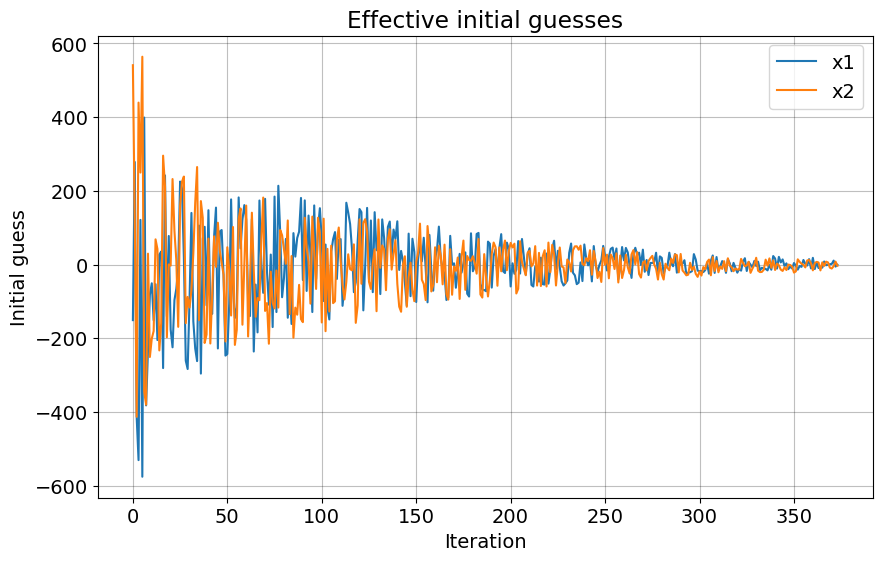

In [25]:
# Define the Griewank function
def griewank(x):
    A = x[0]**2/4000 + x[1]**2/4000
    B = np.cos(x[0]/np.sqrt(1))*np.cos(x[1]/np.sqrt(2))
    return A - B + 1

# Set the parameters
bounds = np.array([[-600, 600], [-600, 600]])
tol = 10**(-8)
K_underline = 10
K_max = 1000

# Set the seed for reproducibility
np.random.seed(42)

# Initialize the results
X_star = None
f_star = np.inf
X_k0 = []
iteration_k = []

# Perform the multi-start optimization
for k in range(K_max):
    # Draw a random initial guess
    X_k = np.random.uniform(bounds[:, 0], bounds[:, 1])
    
    # After the warm-up, mix in the best solution so far
    if k >= K_underline:
        chi_k = 0.5 * (2 / (1 + np.exp((k - K_underline) / 100)))
        X_k = chi_k * X_k + (1 - chi_k) * X_star
    
    # Run the BFGS optimizer
    result = minimize(griewank, X_k, method='BFGS', tol=tol)
    X_k_star = result.x
    f_k_star = result.fun

    # Save the effective initial guess for later plotting
    X_k0.append(X_k)
    iteration_k.append(k)
    
    # Update the best solution
    if f_k_star < f_star:
        X_star = X_k_star
        f_star = f_k_star

    # Check if the solution is good enough
    if f_star < tol:
        break

# Print the results
print(f"Optimal solution: X* = {X_star} which is the values for x1 and x2, and f(X*) = {f_star} which is close to zero")
# Print the maximum value in iteration_k
max_iteration = np.max(iteration_k)
print(f"Maximum iteration: {max_iteration}")
# Plot the effective initial guesses
X_k0 = np.array(X_k0)
plt.figure(figsize=(10, 6))
plt.plot(iteration_k, X_k0[:, 0], label='x1')
plt.plot(iteration_k, X_k0[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial guess')
plt.legend()
plt.title('Effective initial guesses')
plt.show()


The function value is very close to zero which is close to the global minimum. This demonstrates the effectiveness of the global optimizer.

The algorithm reached an optimal solution in 373 iterations where the first 10 was random, showing that it could find the solution before reaching the maximum.

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Optimal solution: X* = [-1.70276503e-08 -1.56819276e-09] which is the values for x1 and x2, and f(X*) = 1.1102230246251565e-16 which is close to zero
Maximum iteration: 477


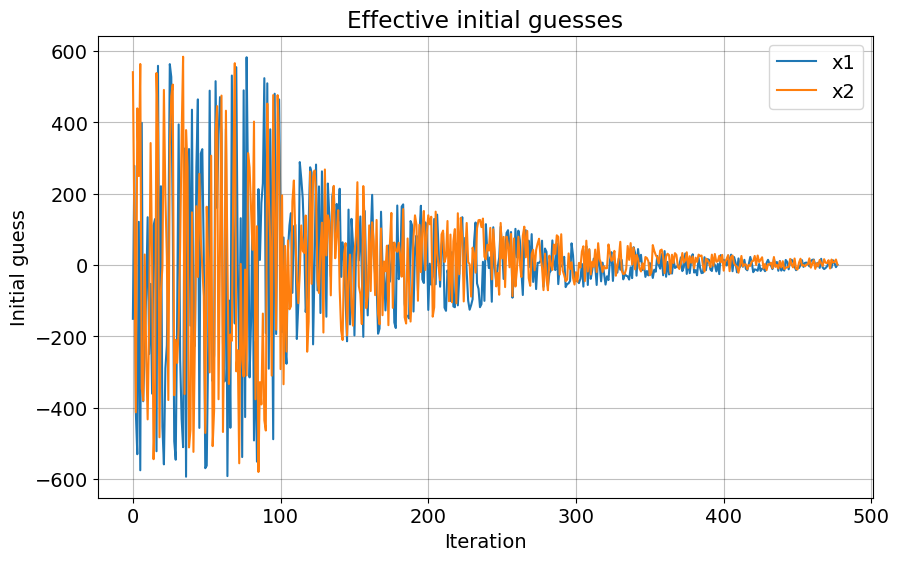

In [26]:
# write your code here
#Same code as previous question excep for K_underline = 100 now
# Define the Griewank function
def griewank(x):
    A = x[0]**2/4000 + x[1]**2/4000
    B = np.cos(x[0]/np.sqrt(1))*np.cos(x[1]/np.sqrt(2))
    return A - B + 1

# Set the parameters
bounds = np.array([[-600, 600], [-600, 600]])
tol = 10**(-8)
K_underline = 100
K_max = 1000

# Set the seed for reproducibility
np.random.seed(42)

# Initialize the results
X_star = None
f_star = np.inf
X_k0 = []
iteration_k = []

# Perform the multi-start optimization
for k in range(K_max):
    # Draw a random initial guess
    X_k = np.random.uniform(bounds[:, 0], bounds[:, 1])
    
    # After the warm-up, mix in the best solution so far
    if k >= K_underline:
        chi_k = 0.5 * (2 / (1 + np.exp((k - K_underline) / 100)))
        X_k = chi_k * X_k + (1 - chi_k) * X_star
    
    # Run the BFGS optimizer
    result = minimize(griewank, X_k, method='BFGS', tol=tol)
    X_k_star = result.x
    f_k_star = result.fun

    # Save the effective initial guess for later plotting
    X_k0.append(X_k)
    iteration_k.append(k)
    
    # Update the best solution
    if f_k_star < f_star:
        X_star = X_k_star
        f_star = f_k_star

    # Check if the solution is good enough
    if f_star < tol:
        break

# Print the results
print(f"Optimal solution: X* = {X_star} which is the values for x1 and x2, and f(X*) = {f_star} which is close to zero")
# Print the maximum value in iteration_k
max_iteration = np.max(iteration_k)
print(f"Maximum iteration: {max_iteration}")
# Plot the effective initial guesses
X_k0 = np.array(X_k0)
plt.figure(figsize=(10, 6))
plt.plot(iteration_k, X_k0[:, 0], label='x1')
plt.plot(iteration_k, X_k0[:, 1], label='x2')
plt.xlabel('Iteration')
plt.ylabel('Initial guess')
plt.legend()
plt.title('Effective initial guesses')
plt.show()


The idea behind the initial iterations is to perform a number of  random guesses before we start to add a bias in the search towards the best solution . Increasing $\underline{K}$, basically means that we add random guesses for a longer time before starting to explore the best solutions that has been found